In [33]:
import pickle, gzip, numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math


def plot_images(X):
    if X.ndim == 1:
        X = np.array([X])
    num_images = X.shape[0]
    num_rows = math.floor(math.sqrt(num_images))
    num_cols = math.ceil(num_images/num_rows)
    for i in range(num_images):
        reshaped_image = X[i,:].reshape(28,28)
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(reshaped_image, cmap = cm.Greys_r)
        plt.axis('off')
    plt.show()


def pick_examples_of(X, Y, labels, total_count):
    bool_arr = None
    for label in labels:
        bool_arr_for_label = (Y == label)
        if bool_arr is None:
            bool_arr = bool_arr_for_label
        else:
            bool_arr |= bool_arr_for_label
    filtered_x = X[bool_arr]
    filtered_y = Y[bool_arr]
    return (filtered_x[:total_count], filtered_y[:total_count])


def extract_training_and_test_examples_with_labels(train_x, train_y, test_x, test_y, labels, training_count, test_count):
    filtered_train_x, filtered_train_y = pick_examples_of(train_x, train_y, labels, training_count)
    filtered_test_x, filtered_test_y = pick_examples_of(test_x, test_y, labels, test_count)
    return (filtered_train_x, filtered_train_y, filtered_test_x, filtered_test_y)

def write_pickle_data(data, file_name):
    f = gzip.open(file_name, 'wb')
    pickle.dump(data, f)
    f.close()

def read_pickle_data(file_name):
    f = gzip.open(file_name, 'rb')
    data = pickle.load(f, encoding='latin1')
    f.close()
    return data

def get_MNIST_data():
    """
    Reads mnist dataset from file

    Returns:
        train_x - 2D Numpy array (n, d) where each row is an image
        train_y - 1D Numpy array (n, ) where each row is a label
        test_x  - 2D Numpy array (n, d) where each row is an image
        test_y  - 1D Numpy array (n, ) where each row is a label

    """
    train_set, valid_set, test_set = read_pickle_data('Datasets/mnist.pkl.gz')
    train_x, train_y = train_set
    valid_x, valid_y = valid_set
    train_x = np.vstack((train_x, valid_x))
    train_y = np.append(train_y, valid_y)
    test_x, test_y = test_set
    return (train_x, train_y, test_x, test_y)

def load_train_and_test_pickle(file_name):
    train_x, train_y, test_x, test_y = read_pickle_data(file_name)
    return train_x, train_y, test_x, test_y

# returns the feature set in a numpy ndarray
def load_CSV(filename):
    stuff = np.asarray(np.loadtxt(open(filename, 'rb'), delimiter=','))
    return stuff


In [34]:
# Importing all libraries
import warnings
import numpy as np
from sklearn.svm import LinearSVC
import scipy.sparse as sparse

# Suppress warnings:
def warn(*args, **kwargs):
    pass

warnings.warn = warn

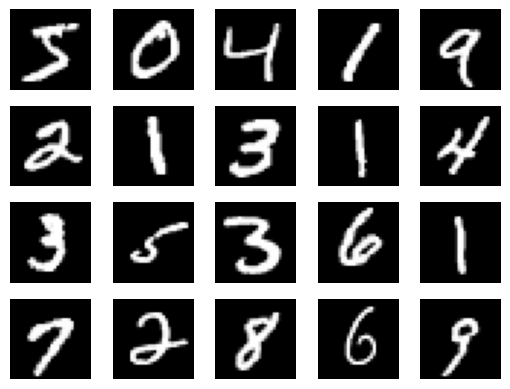

In [35]:
train_x, train_y, test_x, test_y = get_MNIST_data()
plot_images(train_x[0:20, :])

# Linear Regression with Closed Form Solution

In [36]:
def closed_form(X, Y, lambda_factor):
    """
    Computes the closed form solution of linear regression with L2 regularization

    Args:
        X - (n, d + 1) NumPy array (n datapoints each with d features plus the bias feature in the first dimension)
        Y - (n, ) NumPy array containing the labels (a number from 0-9) for each
            data point
        lambda_factor - the regularization constant (scalar)
    Returns:
        theta - (d + 1, ) NumPy array containing the weights of linear regression. Note that theta[0]
        represents the y-axis intercept of the model and therefore X[0] = 1
    """
    identity_matrix = np.identity(X.shape[1])
    theta = np.linalg.inv(X.T.dot(X) + lambda_factor * identity_matrix).dot(X.T).dot(Y)

    return theta

In [37]:
def compute_test_error_linear(test_x, Y, theta):
    test_y_predict = np.round(np.dot(test_x, theta))
    test_y_predict[test_y_predict < 0] = 0
    test_y_predict[test_y_predict > 9] = 9
    return 1 - np.mean(test_y_predict == Y)

In [38]:
def run_linear_regression_on_MNIST(lambda_factor=1):
    """
    Trains linear regression, classifies test data, computes test error on test set

    Returns:
        Final test error
    """
    train_x, train_y, test_x, test_y = get_MNIST_data()
    train_x_bias = np.hstack([np.ones([train_x.shape[0], 1]), train_x])
    test_x_bias = np.hstack([np.ones([test_x.shape[0], 1]), test_x])
    theta = closed_form(train_x_bias, train_y, lambda_factor)
    test_error = compute_test_error_linear(test_x_bias, test_y, theta)
    return test_error

In [39]:
print('Linear Regression test_error =', run_linear_regression_on_MNIST(lambda_factor=1))

Linear Regression test_error = 0.7697


# Support Vector Machine

In [40]:
def one_vs_rest_svm(train_x, train_y, test_x):
    """
    Trains a linear SVM for binary classifciation

    Args:
        train_x - (n, d) NumPy array (n datapoints each with d features)
        train_y - (n, ) NumPy array containing the labels (0 or 1) for each training data point
        test_x - (m, d) NumPy array (m datapoints each with d features)
    Returns:
        pred_test_y - (m,) NumPy array containing the labels (0 or 1) for each test data point
    """
    clf = LinearSVC(C = 0.1, random_state = 0)
    clf.fit(train_x, train_y)

    pred_test_y = clf.predict(test_x)

    return pred_test_y


In [41]:
def multi_class_svm(train_x, train_y, test_x):
    """
    Trains a linear SVM for multiclass classification using a one-vs-rest strategy

    Args:
        train_x - (n, d) NumPy array (n datapoints each with d features)
        train_y - (n, ) NumPy array containing the labels (int) for each training data point
        test_x - (m, d) NumPy array (m datapoints each with d features)
    Returns:
        pred_test_y - (m,) NumPy array containing the labels (int) for each test data point
    """
    # Train a linear SVM with one-vs-rest strategy
    clf = LinearSVC(C=0.1, random_state=0, multi_class='ovr', max_iter=5000)
    clf.fit(train_x, train_y)

    # Predict on the test data
    pred_test_y = clf.predict(test_x)

    return pred_test_y

In [42]:
def compute_test_error_svm(test_y, pred_test_y):
    return 1 - np.mean(pred_test_y == test_y)

In [43]:
def run_svm_one_vs_rest_on_MNIST():
    """
    Trains svm, classifies test data, computes test error on test set

    Returns:
        Test error for the binary svm
    """
    train_x, train_y, test_x, test_y = get_MNIST_data()
    train_y[train_y != 0] = 1
    test_y[test_y != 0] = 1
    pred_test_y = one_vs_rest_svm(train_x, train_y, test_x)
    test_error = compute_test_error_svm(test_y, pred_test_y)
    return test_error


print('SVM one vs. rest test_error:', run_svm_one_vs_rest_on_MNIST())

SVM one vs. rest test_error: 0.007499999999999951


In [44]:
def run_multiclass_svm_on_MNIST():
    """
    Trains svm, classifies test data, computes test error on test set

    Returns:
        Test error for the binary svm
    """
    train_x, train_y, test_x, test_y = get_MNIST_data()
    pred_test_y = multi_class_svm(train_x, train_y, test_x)
    test_error = compute_test_error_svm(test_y, pred_test_y)
    return test_error


print('Multiclass SVM test_error:', run_multiclass_svm_on_MNIST())

Multiclass SVM test_error: 0.08189999999999997


# Multinomial (Softmax) Regression and Gradient Descent

In [45]:
def compute_probabilities(X, theta, temp_parameter):
    """
    Computes, for each datapoint X[i], the probability that X[i] is labeled as j
    for j = 0, 1, ..., k-1

    Args:
        X - (n, d) NumPy array (n datapoints each with d features)
        theta - (k, d) NumPy array, where row j represents the parameters of our model for label j
        temp_parameter - the temperature parameter of softmax function (scalar)
    Returns:
        H - (k, n) NumPy array, where each entry H[j][i] is the probability that X[i] is labeled as j
    """
    R = (theta.dot(X.T))/temp_parameter
    c = np.max(R, axis = 0)
    H = np.exp(R - c)
    H = H/np.sum(H, axis = 0)

    return H 

In [46]:
def augment_feature_vector(X):
    """
    Adds the x[i][0] = 1 feature for each data point x[i].

    Args:
        X - a NumPy matrix of n data points, each with d - 1 features

    Returns: X_augment, an (n, d) NumPy array with the added feature for each datapoint
    """
    column_of_ones = np.zeros([len(X), 1]) + 1
    return np.hstack((column_of_ones, X))

In [47]:
def compute_cost_function(X, Y, theta, lambda_factor, temp_parameter):
    """
    Computes the total cost over every datapoint.

    Args:
        X - (n, d) NumPy array (n datapoints each with d features)
        Y - (n, ) NumPy array containing the labels (a number from 0-9) for each
            data point
        theta - (k, d) NumPy array, where row j represents the parameters of our
                model for label j
        lambda_factor - the regularization constant (scalar)
        temp_parameter - the temperature parameter of softmax function (scalar)

    Returns
        c - the cost value (scalar)
    """
    k = theta.shape[0]
    n = X.shape[0]
    clip_prob_matrix = np.clip(compute_probabilities(X, theta, temp_parameter), 1e-15, 1-1e-15)
    log_clip_matrix = np.log(clip_prob_matrix)
    M = sparse.coo_matrix(([1]*n, (Y, range(n))), shape = (k,n)).toarray()
    error_term = (-1/n)*np.sum(log_clip_matrix[M == 1])
    reg_term = (lambda_factor/2)*np.linalg.norm(theta)**2

    return error_term + reg_term

In [48]:
def run_gradient_descent_iteration(X, Y, theta, alpha, lambda_factor, temp_parameter):
    """
    Runs one step of batch gradient descent

    Args:
        X - (n, d) NumPy array (n datapoints each with d features)
        Y - (n, ) NumPy array containing the labels (a number from 0-9) for each
            data point
        theta - (k, d) NumPy array, where row j represents the parameters of our
                model for label j
        alpha - the learning rate (scalar)
        lambda_factor - the regularization constant (scalar)
        temp_parameter - the temperature parameter of softmax function (scalar)

    Returns:
        theta - (k, d) NumPy array that is the final value of parameters theta
    """
    k = theta.shape[0]
    n = X.shape[0]
    M = sparse.coo_matrix(([1]*n, (Y, range(n))), shape=(k,n)).toarray()
    P = compute_probabilities(X, theta, temp_parameter)
    grad_theta = (-1/(temp_parameter*n))*((M - P) @ X) + lambda_factor*theta
    theta = theta - alpha*grad_theta

    return theta

In [49]:
def update_y(train_y, test_y):
    """
    Changes the old digit labels for the training and test set for the new (mod 3)
    labels.

    Args:
        train_y - (n, ) NumPy array containing the labels (a number between 0-9)
                 for each datapoint in the training set
        test_y - (n, ) NumPy array containing the labels (a number between 0-9)
                for each datapoint in the test set

    Returns:
        train_y_mod3 - (n, ) NumPy array containing the new labels (a number between 0-2)
                     for each datapoint in the training set
        test_y_mod3 - (n, ) NumPy array containing the new labels (a number between 0-2)
                    for each datapoint in the test set
    """
    train_y_mod3 = np.mod(train_y, 3)
    test_y_mod3 = np.mod(test_y, 3)

    return (train_y_mod3, test_y_mod3)

In [50]:
def compute_test_error_mod3(X, Y, theta, temp_parameter):
    """
    Returns the error of these new labels when the classifier predicts the digit. (mod 3)

    Args:
        X - (n, d - 1) NumPy array (n datapoints each with d - 1 features)
        Y - (n, ) NumPy array containing the labels (a number from 0-2) for each
            data point
        theta - (k, d) NumPy array, where row j represents the parameters of our
                model for label j
        temp_parameter - the temperature parameter of softmax function (scalar)

    Returns:
        test_error - the error rate of the classifier (scalar)
    """
    y_pred = get_classification(X, theta, temp_parameter)

    return 1 - (np.mod(y_pred, 3) == Y).mean()


In [83]:
def softmax_regression(X, Y, temp_parameter, alpha, lambda_factor, k, num_iterations):
    """
    Runs batch gradient descent for a specified number of iterations on a dataset
    with theta initialized to the all-zeros array. Here, theta is a k by d NumPy array
    where row j represents the parameters of our model for label j for
    j = 0, 1, ..., k-1

    Args:
        X - (n, d - 1) NumPy array (n data points, each with d-1 features)
        Y - (n, ) NumPy array containing the labels (a number from 0-9) for each
            data point
        temp_parameter - the temperature parameter of softmax function (scalar)
        alpha - the learning rate (scalar)
        lambda_factor - the regularization constant (scalar)
        k - the number of labels (scalar)
        num_iterations - the number of iterations to run gradient descent (scalar)

    Returns:
        theta - (k, d) NumPy array that is the final value of parameters theta
        cost_function_progression - a Python list containing the cost calculated at each step of gradient descent
    """
    X = augment_feature_vector(X)
    theta = np.zeros([k, X.shape[1]])
    cost_function_progression = []
    for i in range(num_iterations):
        cost_function_progression.append(compute_cost_function(X, Y, theta, lambda_factor, temp_parameter))
        theta = run_gradient_descent_iteration(X, Y, theta, alpha, lambda_factor, temp_parameter)
    return theta, cost_function_progression

def get_classification(X, theta, temp_parameter):
    """
    Makes predictions by classifying a given dataset

    Args:
        X - (n, d - 1) NumPy array (n data points, each with d - 1 features)
        theta - (k, d) NumPy array where row j represents the parameters of our model for
                label j
        temp_parameter - the temperature parameter of softmax function (scalar)

    Returns:
        Y - (n, ) NumPy array, containing the predicted label (a number between 0-9) for
            each data point
    """
    X = augment_feature_vector(X)
    probabilities = compute_probabilities(X, theta, temp_parameter)
    return np.argmax(probabilities, axis = 0)

def plot_cost_function_over_time(cost_function_history):
    plt.plot(range(len(cost_function_history)), cost_function_history)
    plt.ylabel('Cost Function')
    plt.xlabel('Iteration number')
    plt.show()

def compute_test_error(X, Y, theta, temp_parameter):
    error_count = 0.
    assigned_labels = get_classification(X, theta, temp_parameter)
    return 1 - np.mean(assigned_labels == Y)

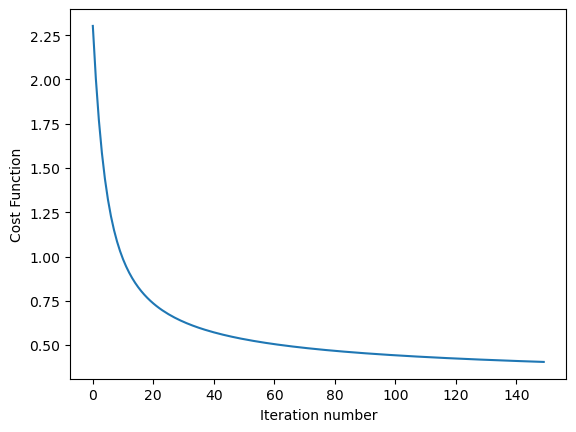

softmax test_error= 0.10050000000000003


In [52]:
def run_softmax_on_MNIST(temp_parameter=1):
    """
    Trains softmax, classifies test data, computes test error, and plots cost function

    Runs softmax_regression on the MNIST training set and computes the test error using
    the test set. It uses the following values for parameters:
    alpha = 0.3
    lambda = 1e-4
    num_iterations = 150

    Saves the final theta to ./theta.pkl.gz

    Returns:
        Final test error
    """
    train_x, train_y, test_x, test_y = get_MNIST_data()
    theta, cost_function_history = softmax_regression(train_x, train_y, temp_parameter, alpha=0.3, lambda_factor=1.0e-4, k=10, num_iterations=150)
    plot_cost_function_over_time(cost_function_history)
    test_error = compute_test_error(test_x, test_y, theta, temp_parameter)
    # Save the model parameters theta obtained from calling softmax_regression to disk.
    write_pickle_data(theta, "./theta.pkl.gz")

    # TODO: add your code here for the "Using the Current Model" question in tab 6.
    #      and print the test_error_mod3
    return test_error


print('softmax test_error=', run_softmax_on_MNIST(temp_parameter=1))

# Temperature

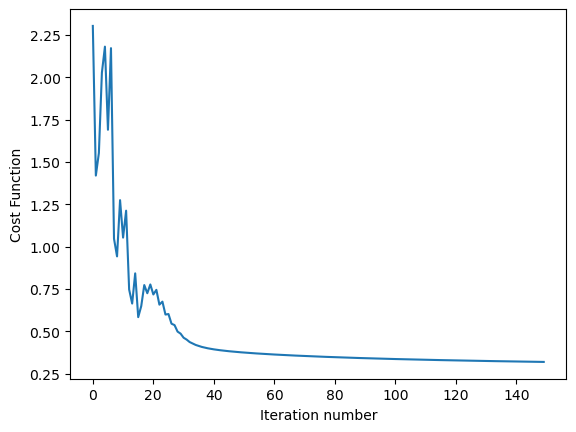

softmax test_error= 0.08399999999999996


In [53]:
def run_softmax_on_MNIST(temp_parameter=0.5):
    """
    Trains softmax, classifies test data, computes test error, and plots cost function

    Runs softmax_regression on the MNIST training set and computes the test error using
    the test set. It uses the following values for parameters:
    alpha = 0.3
    lambda = 1e-4
    num_iterations = 150

    Saves the final theta to ./theta.pkl.gz

    Returns:
        Final test error
    """
    train_x, train_y, test_x, test_y = get_MNIST_data()
    theta, cost_function_history = softmax_regression(train_x, train_y, temp_parameter, alpha=0.3, lambda_factor=1.0e-4, k=10, num_iterations=150)
    plot_cost_function_over_time(cost_function_history)
    test_error = compute_test_error(test_x, test_y, theta, temp_parameter)
    # Save the model parameters theta obtained from calling softmax_regression to disk.
    write_pickle_data(theta, "./theta.pkl.gz")

    # TODO: add your code here for the "Using the Current Model" question in tab 6.
    #      and print the test_error_mod3
    return test_error


print('softmax test_error=', run_softmax_on_MNIST(temp_parameter=0.5))

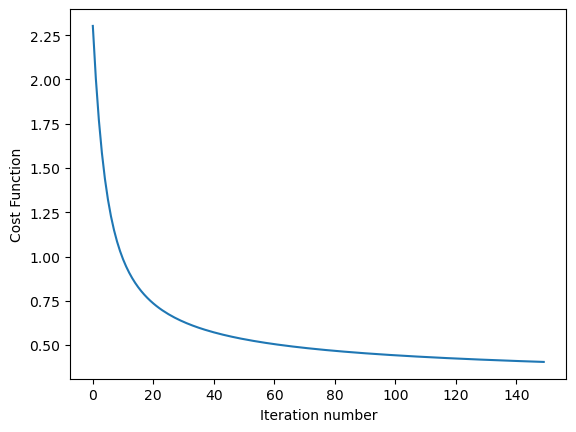

softmax test_error= 0.10050000000000003


In [54]:
def run_softmax_on_MNIST(temp_parameter=1):
    """
    Trains softmax, classifies test data, computes test error, and plots cost function

    Runs softmax_regression on the MNIST training set and computes the test error using
    the test set. It uses the following values for parameters:
    alpha = 0.3
    lambda = 1e-4
    num_iterations = 150

    Saves the final theta to ./theta.pkl.gz

    Returns:
        Final test error
    """
    train_x, train_y, test_x, test_y = get_MNIST_data()
    theta, cost_function_history = softmax_regression(train_x, train_y, temp_parameter, alpha=0.3, lambda_factor=1.0e-4, k=10, num_iterations=150)
    plot_cost_function_over_time(cost_function_history)
    test_error = compute_test_error(test_x, test_y, theta, temp_parameter)
    # Save the model parameters theta obtained from calling softmax_regression to disk.
    write_pickle_data(theta, "./theta.pkl.gz")

    # TODO: add your code here for the "Using the Current Model" question in tab 6.
    #      and print the test_error_mod3
    return test_error


print('softmax test_error=', run_softmax_on_MNIST(temp_parameter=1))

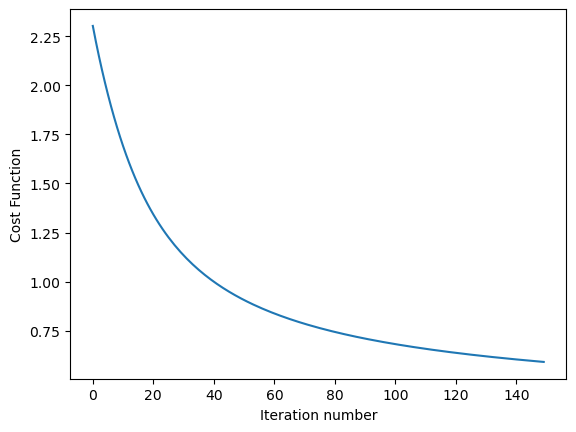

softmax test_error= 0.1261


In [55]:
def run_softmax_on_MNIST(temp_parameter=2):
    """
    Trains softmax, classifies test data, computes test error, and plots cost function

    Runs softmax_regression on the MNIST training set and computes the test error using
    the test set. It uses the following values for parameters:
    alpha = 0.3
    lambda = 1e-4
    num_iterations = 150

    Saves the final theta to ./theta.pkl.gz

    Returns:
        Final test error
    """
    train_x, train_y, test_x, test_y = get_MNIST_data()
    theta, cost_function_history = softmax_regression(train_x, train_y, temp_parameter, alpha=0.3, lambda_factor=1.0e-4, k=10, num_iterations=150)
    plot_cost_function_over_time(cost_function_history)
    test_error = compute_test_error(test_x, test_y, theta, temp_parameter)
    # Save the model parameters theta obtained from calling softmax_regression to disk.
    write_pickle_data(theta, "./theta.pkl.gz")

    # TODO: add your code here for the "Using the Current Model" question in tab 6.
    #      and print the test_error_mod3
    return test_error


print('softmax test_error=', run_softmax_on_MNIST(temp_parameter=2))

# Changing Labels

In [56]:
def compute_test_error_mod3(X, Y, theta, temp_parameter):
    y_pred = get_classification(X, theta, temp_parameter)
    y_pred_mod3 = np.mod(y_pred, 3)
    Y_mod3 = np.mod(Y, 3)
    return 1 - np.mean(y_pred_mod3 == Y_mod3)

def run_softmax_on_MNIST(temp_parameter=1):
    """
    Trains softmax, classifies test data, computes test error, and plots cost function

    Runs softmax_regression on the MNIST training set and computes the test error using
    the test set. It uses the following values for parameters:
    alpha = 0.3
    lambda = 1e-4
    num_iterations = 150

    Saves the final theta to ./theta.pkl.gz

    Returns:
        Final test error
    """
    train_x, train_y, test_x, test_y = get_MNIST_data()
    theta, cost_function_history = softmax_regression(train_x, train_y, temp_parameter, alpha=0.3, lambda_factor=1.0e-4, k=10, num_iterations=150)
    test_error_mod3 = compute_test_error_mod3(test_x, test_y, theta, temp_parameter)  # Computing the mod 3 test error

    # Print the results
    print('softmax test_error_mod3=', test_error_mod3)

    return test_error_mod3


In [57]:
done=run_softmax_on_MNIST()

softmax test_error_mod3= 0.07679999999999998


In [58]:
def run_softmax_on_MNIST_mod3(temp_parameter=1):
    """
    Trains Softmax regression on digit (mod 3) classifications.

    See run_softmax_on_MNIST for more info.
    """
    train_x, train_y, test_x, test_y = get_MNIST_data()
    train_y_mod3, test_y_mod3 = update_y(train_y, test_y)
    theta, cost_function_history = softmax_regression(train_x, train_y_mod3, temp_parameter, alpha= 0.3, lambda_factor = 1.0e-4, k = 10, num_iterations = 150)
    plot_cost_function_over_time(cost_function_history)
    test_error = compute_test_error(test_x, test_y_mod3, theta, temp_parameter)
    return test_error

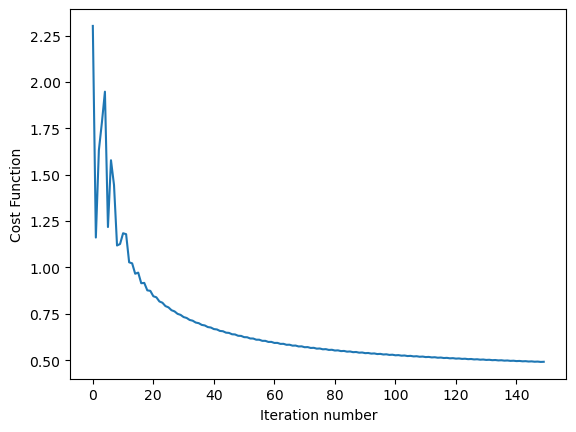

0.18720000000000003

In [59]:
run_softmax_on_MNIST_mod3()

# Dimensionality Reduction Using PCA

In [60]:
def project_onto_PC(X, pcs, n_components, feature_means):
    """
    Given principal component vectors pcs = principal_components(X)
    this function returns a new data array in which each sample in X
    has been projected onto the first n_components principcal components.
    """
    # TODO: first center data using the feature_means
    # TODO: Return the projection of the centered dataset
    #       on the first n_components principal components.
    #       This should be an array with dimensions: n x n_components.
    # Hint: these principal components = first n_components columns
    #       of the eigenvectors returned by principal_components().
    #       Note that each eigenvector is already be a unit-vector,
    #       so the projection may be done using matrix multiplication.
    X_centered = center_data(X)
    V_n = pcs[:,0:n_components]
    projected_data = X_centered @ V_n
    return projected_data


In [61]:
def cubic_features(X):
    """
    Returns a new dataset with features given by the mapping
    which corresponds to the cubic kernel.
    """
    n, d = X.shape  # dataset size, input dimension
    X_withones = np.ones((n, d + 1))
    X_withones[:, :-1] = X
    new_d = 0  # dimension of output
    new_d = int((d + 1) * (d + 2) * (d + 3) / 6)

    new_data = np.zeros((n, new_d))
    col_index = 0
    for x_i in range(n):
        X_i = X[x_i]
        X_i = X_i.reshape(1, X_i.size)

        if d > 2:
            comb_2 = np.matmul(np.transpose(X_i), X_i)

            unique_2 = comb_2[np.triu_indices(d, 1)]
            unique_2 = unique_2.reshape(unique_2.size, 1)
            comb_3 = np.matmul(unique_2, X_i)
            keep_m = np.zeros(comb_3.shape)
            index = 0
            for i in range(d - 1):
                keep_m[index + np.arange(d - 1 - i), i] = 0

                tri_keep = np.triu_indices(d - 1 - i, 1)

                correct_0 = tri_keep[0] + index
                correct_1 = tri_keep[1] + i + 1

                keep_m[correct_0, correct_1] = 1
                index += d - 1 - i

            unique_3 = np.sqrt(6) * comb_3[np.nonzero(keep_m)]

            new_data[x_i, np.arange(unique_3.size)] = unique_3
            col_index = unique_3.size

    for i in range(n):
        newdata_colindex = col_index
        for j in range(d + 1):
            new_data[i, newdata_colindex] = X_withones[i, j]**3
            newdata_colindex += 1
            for k in range(j + 1, d + 1):
                new_data[i, newdata_colindex] = X_withones[i, j]**2 * X_withones[i, k] * (3**(0.5))
                newdata_colindex += 1

                new_data[i, newdata_colindex] = X_withones[i, j] * X_withones[i, k]**2 * (3**(0.5))
                newdata_colindex += 1

                if k < d:
                    new_data[i, newdata_colindex] = X_withones[i, j] * X_withones[i, k] * (6**(0.5))
                    newdata_colindex += 1

    return new_data


def center_data(X):
    """
    Returns a centered version of the data, where each feature now has mean = 0

    Args:
        X - n x d NumPy array of n data points, each with d features

    Returns:
        - (n, d) NumPy array X' where for each i = 1, ..., n and j = 1, ..., d:
        X'[i][j] = X[i][j] - means[j]       
	- (d, ) NumPy array with the columns means

    """
    feature_means = X.mean(axis=0)
    return (X - feature_means), feature_means


def principal_components(centered_data):
    """
    Returns the principal component vectors of the data, sorted in decreasing order
    of eigenvalue magnitude. This function first calculates the covariance matrix
    and then finds its eigenvectors.

    Args:
        centered_data - n x d NumPy array of n data points, each with d features

    Returns:
        d x d NumPy array whose columns are the principal component directions sorted
        in descending order by the amount of variation each direction (these are
        equivalent to the d eigenvectors of the covariance matrix sorted in descending
        order of eigenvalues, so the first column corresponds to the eigenvector with
        the largest eigenvalue
    """
    scatter_matrix = np.dot(centered_data.transpose(), centered_data)
    eigen_values, eigen_vectors = np.linalg.eig(scatter_matrix)
    # Re-order eigenvectors by eigenvalue magnitude:
    idx = eigen_values.argsort()[::-1]
    eigen_values = eigen_values[idx]
    eigen_vectors = eigen_vectors[:, idx]
    return eigen_vectors


###Correction note:  Differing from the release, this function takes an extra input feature_means.

def plot_PC(X, pcs, labels, feature_means):
    """
    Given the principal component vectors as the columns of matrix pcs,
    this function projects each sample in X onto the first two principal components
    and produces a scatterplot where points are marked with the digit depicted in
    the corresponding image.
    labels = a numpy array containing the digits corresponding to each image in X.
    """
    pc_data = project_onto_PC(X, pcs, n_components=2, feature_means=feature_means)
    text_labels = [str(z) for z in labels.tolist()]
    fig, ax = plt.subplots()
    ax.scatter(pc_data[:, 0], pc_data[:, 1], alpha=0, marker=".")
    for i, txt in enumerate(text_labels):
        ax.annotate(txt, (pc_data[i, 0], pc_data[i, 1]))
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    plt.show()


###Correction note:  Differing from the release, this function takes an extra input feature_means.

def reconstruct_PC(x_pca, pcs, n_components, X, feature_means):
    """
    Given the principal component vectors as the columns of matrix pcs,
    this function reconstructs a single image from its principal component
    representation, x_pca.
    X = the original data to which PCA was applied to get pcs.
    """
    x_reconstructed = np.dot(x_pca, pcs[:, range(n_components)].T) + feature_means
    return x_reconstructed

In [64]:
def project_onto_PC(X, pcs, n_components, feature_means):
    """
    Given principal component vectors pcs = principal_components(X)
    this function returns a new data array in which each sample in X
    has been projected onto the first n_components principcal components.
    """
    # TODO: first center data using the feature_means
    # TODO: Return the projection of the centered dataset
    #       on the first n_components principal components.
    #       This should be an array with dimensions: n x n_components.
    # Hint: these principal components = first n_components columns
    #       of the eigenvectors returned by principal_components().
    #       Note that each eigenvector is already be a unit-vector,
    #       so the projection may be done using matrix multiplication.
    X_centered, _ = center_data(X)
    V_n = pcs[:,0:n_components]
    projected_data = X_centered @ V_n
    return projected_data


In [ ]:
n_components = 18
train_x_centered, feature_means = center_data(train_x)
pcs = principal_components(train_x_centered)
train_pca = project_onto_PC(train_x, pcs, n_components, feature_means)
test_pca = project_onto_PC(test_x, pcs, n_components, feature_means)


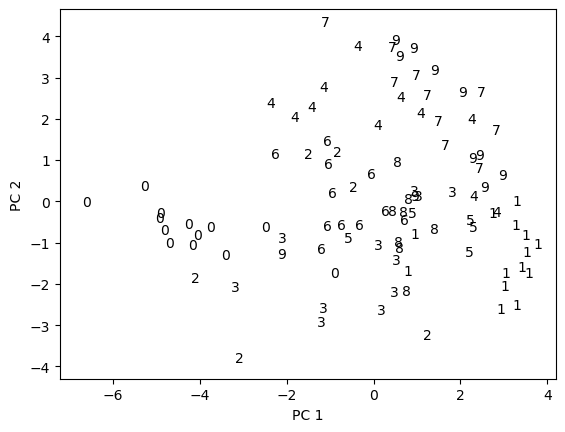

In [66]:
plot_PC(train_x[range(000, 100), ], pcs, train_y[range(000, 100)], feature_means)

# Kernel Methods

In [68]:
def polynomial_kernel(X, Y, c, p):
    """
        Compute the polynomial kernel between two matrices X and Y::
            K(x, y) = (<x, y> + c)^p
        for each pair of rows x in X and y in Y.

        Args:
            X - (n, d) NumPy array (n datapoints each with d features)
            Y - (m, d) NumPy array (m datapoints each with d features)
            c - a coefficient to trade off high-order and low-order terms (scalar)
            p - the degree of the polynomial kernel

        Returns:
            kernel_matrix - (n, m) Numpy array containing the kernel matrix
    """
    kernel_matrix = (X.dot(Y.T) + c)**p

    return kernel_matrix

In [69]:
def rbf_kernel(X, Y, gamma):
    """
        Compute the Gaussian RBF kernel between two matrices X and Y::
            K(x, y) = exp(-gamma ||x-y||^2)
        for each pair of rows x in X and y in Y.

        Args:
            X - (n, d) NumPy array (n datapoints each with d features)
            Y - (m, d) NumPy array (m datapoints each with d features)
            gamma - the gamma parameter of gaussian function (scalar)

        Returns:
            kernel_matrix - (n, m) Numpy array containing the kernel matrix
    """
    squared_distances = np.sum(X**2, axis=1).reshape(-1, 1) + np.sum(Y**2, axis=1) - 2 * X.dot(Y.T)

    # Compute the RBF kernel
    kernel_matrix = np.exp(-gamma * squared_distances)

    return kernel_matrix

# Cubic Features

In [91]:
def project_onto_PC(X, pcs, n_components, feature_means):
    """
    Given principal component vectors pcs = principal_components(X)
    this function returns a new data array in which each sample in X
    has been projected onto the first n_components principal components.
    """
    # Center the data using the provided feature_means
    X_centered = X - feature_means

    # Get the first n_components principal components
    V_n = pcs[:, 0:n_components]

    # Project the centered data onto the principal components
    projected_data = X_centered @ V_n

    return projected_data


In [92]:
n_components = 10
train_x_centered, feature_means = center_data(train_x)
pcs = principal_components(train_x_centered)
train_pca = project_onto_PC(train_x, pcs, n_components, feature_means)
test_pca = project_onto_PC(test_x, pcs, n_components, feature_means)
train_cubic = cubic_features(train_pca)
test_cubic = cubic_features(test_pca)
theta, _ = softmax_regression(train_cubic, train_y, temp_parameter=1.0, alpha=0.3, lambda_factor=1.0e-4, k=10, num_iterations=150)
test_error = compute_test_error(test_cubic, test_y, theta, temp_parameter=1)
print(f"Test error after applying cubic features on PCA representations: {test_error}")


Test error after applying cubic features on PCA representations: 0.08489999999999998


In [93]:
n_components = 10
train_x_centered, feature_means = center_data(train_x)
pcs = principal_components(train_x_centered)
train_pca = project_onto_PC(train_x, pcs, n_components, feature_means)
test_pca = project_onto_PC(test_x, pcs, n_components, feature_means)


In [94]:
from sklearn.svm import SVC

# Initialize the SVM with the given parameters
svm = SVC(kernel='poly', degree=3, random_state=0)

# Train the SVM
svm.fit(train_pca, train_y)


SVC(kernel='poly', random_state=0)

In [95]:
# Predict on the test set
predictions = svm.predict(test_pca)

# Calculate error rate
error_rate = 1 - np.mean(predictions == test_y)
print(f"Error rate for 10-dimensional PCA features using cubic polynomial SVM: {error_rate}")


Error rate for 10-dimensional PCA features using cubic polynomial SVM: 0.07350000000000001


In [96]:
n_components = 10
train_x_centered, feature_means = center_data(train_x)
pcs = principal_components(train_x_centered)
train_pca = project_onto_PC(train_x, pcs, n_components, feature_means)
test_pca = project_onto_PC(test_x, pcs, n_components, feature_means)


In [97]:
from sklearn.svm import SVC

# Initialize the SVM with the given parameters
svm_rbf = SVC(kernel='rbf', random_state=0)

# Train the SVM
svm_rbf.fit(train_pca, train_y)


SVC(random_state=0)

In [98]:
# Predict on the test set
predictions_rbf = svm_rbf.predict(test_pca)

# Calculate error rate
error_rate_rbf = 1 - np.mean(predictions_rbf == test_y)
print(f"Error rate for 10-dimensional PCA features using RBF SVM: {error_rate_rbf}")


Error rate for 10-dimensional PCA features using RBF SVM: 0.06359999999999999
